# Sensitivity curve of Windchime obtained using a semi-analytic approach

_Juehang Qin, July 2021_

In this note, I attempt to estimate the sensitivity of the Windchime experiment using a semi-analytic approach. The following steps are taken:

1. A sensor array is configured. For now, all sensors are pointing in the same direction. It would be interesting to evaluate if sensor orientation would have an impact, but as this code currently does not take into account the diurnal modulation or annual modulation of dark matter, it might be difficult to draw useful conclusions.

2. $N_{tracks}$ tracks are sampled from the standard halo model velocity distribution. These tracks are isotropically distributed, and are parameterised based on where the tracks enter and exit a spherical surface. which I will call the 'analysis sphere' in this note. This is described in detail [here](https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Integral_transform_for_data_analysis.pdf).

3. For each track, the vector pointing each sensor to the closest point on the track is computed. The length of this vector is the impact parameter. Using this, the signal strength that would be obtained, as described in [this note](https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Analytic_SNR_for_a_single_sensor.pdf).

4. The signal strength is divided by the noise, as calculated based on sensor parameters.

5. Step 4 is repeated for different sensor parameters. From this, determine the probability of seeing a given randomly drawn track above some SNR threshold. A threshold 6 is used in this note. This is somewhat arbitrary, and would need to be chosen more rigorously once we have a good estimate of the trial factor of performing analysis on such a large array.

6. Based on the probability of seeing a randomly given track, and the dark matter distribution (standard halo model used), a toy MC is used to run a large number of experiments. The true number of dark matter particles passing through the experiment is modelled as a Poisson random variable, and the number detected is modelled as a binomial random variable. As there is some uncertainty to the probability of the Binomial, that is treated as a random variable too, with a Beta distribution (parameters inferred from step 4).

## Initialisation

Imports, definition of parameters and universal constants.

In [1]:
import numpy as np
from scipy import stats

from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D

from numba import njit
from tqdm import tqdm, trange

/depot/darkmatter/etc/conda/env/anacondark/lib/python3.8/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


In [2]:
## universal constants https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = 6.64730e-11 #m^3/kg/s^2
amu = 1.6605390666e-29 #kg
k_B = 1.380649e-23 #J/K
GeV_per_c2 = 1.7826619218835431593e-27
mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units

In [3]:
N_sensors_x = 101
N_sensors_y = 101
N_sensors_z = 101
length_x = 10 #metre
length_y = 10 #metre
length_z = 10 #metre

# This is the radius of the sphere that is used to parameterise tracks,
# as every track is parameterised by two points on a sphere.
# A radius that is smaller than the detector serves as a form of fiducialisation.
radius = 5 #metre

sensor_coords = np.zeros((3, N_sensors_x*N_sensors_y*N_sensors_z))
coords_1d = (
    np.linspace(-length_x/2, length_x/2, N_sensors_x),
    np.linspace(-length_y/2, length_y/2, N_sensors_y),
    np.linspace(-length_z/2, length_z/2, N_sensors_z),
)

x, y, z = np.meshgrid(*coords_1d, indexing='ij')

sensor_coords[0,:] = x.ravel()
sensor_coords[1,:] = y.ravel()
sensor_coords[2,:] = z.ravel()

sensor_vectors = np.repeat([[0,0,1]], sensor_coords.shape[1], axis=0).T #orientation vectors

sensor_mass = 1e-3 #kg
sensor_density = 1e4 #kg/m^3
min_impact_parameter = (sensor_mass/sensor_density)**(1/3) #metres
gas_pressure = 1e-10 #Pa

In [4]:
# fig = plt.figure(figsize=(8, 6), dpi=100, tight_layout=True)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(sensor_coords[0,:], sensor_coords[1,:], sensor_coords[2,:], s=1)
# plt.show()

In [5]:
N = 1000 #Number of tracks

#generate array of velocities, sampled from the standard halo model
vel = halo_model.generate_vel_array(n_vels=N)
#generate 
entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)

In [6]:
entry_vecs.shape

(3, 1000)

In [7]:
np.repeat(entry_vecs[:,0], 1)

array([-4.86103097,  1.14662948, -0.23583633])

## Signal dunction definition

In [8]:
def find_basis_vectors(sensor_pos, entry_vecs, exit_vecs, only_one_track=False):
    '''
    Find basis vectors and impact vectors.
    The v basis is simply the normalised velocity vector.
    The b basis is the normalised b vector, and the b vector is the vector that points from the sensor to the
    DM particle track, and is orthogonal to said track.
    
    Parameters:
    sensor_pos: coordinates of sensors, 3xN array for N entries.
    entry_vecs: vectors indicating the point at which tracks enter the analysis sphere,
                3xN array for N entries
    exit_vecs: vectors indicating the point at which tracks exit the analysis sphere,
               3xN array for N entries
    '''
    v_dirs = exit_vecs - entry_vecs
    v_bases = v_dirs/np.linalg.norm(v_dirs, axis=0)
    r_disp = entry_vecs-sensor_pos
    d_vecs = np.einsum('ij,ij->j',r_disp,v_bases)*v_bases #dot product
    b_vecs = r_disp - d_vecs
    b_bases = b_vecs/np.linalg.norm(b_vecs, axis=0)

    return(b_bases, v_bases, b_vecs)

def signal(b, v, sensor_vectors, b_bases, v_bases, mass=mass_dm, min_impact_parameter=min_impact_parameter):
    '''the S of the SNR. Based on
    https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Analytic_SNR_for_a_single_sensor.pdf
    
    Parameters:
    b: array of impact parameters.
    v: array of velocity magnitudes.
    sensor_vectors: sensor orientations. 3xN array; individual vectors assumed to be normalised.
    b_bases: b basis vectors for each entry, as defined in find_basis_vectors.
             3xN array; individual vectors assumed to be normalised.
    v_bases: v basis vectors for each entry, as defined in find_basis_vectors.
             3xN array; individual vectors assumed to be normalised.
    mass: dark matter particle mass.
    min_impact_parameter: Smallest allowable impact factor. Smaller impact factors are set to this value.
    '''
    b_dot_n = np.einsum('ij,ij->j',sensor_vectors,b_bases) #dot product
    v_dot_n = np.einsum('ij,ij->j',sensor_vectors,v_bases)
    b[b < min_impact_parameter] = min_impact_parameter
    return G**2*mass**2*np.pi*(3*b_dot_n**2 + v_dot_n**2)/(8*b**3*v)

### Plot to check that vector maths is done correctly

There are also some assert statements to check for the same things.

In [9]:
c = np.repeat(np.array([[0,0,.1]]),N,axis=0)
d = find_basis_vectors(c.T,entry_vecs,exit_vecs)

In [10]:
np.linalg.norm(d[2], axis=0).shape

(1000,)

In [11]:
np.repeat(np.array([[0,0,.1]]),N,axis=0).T.shape

(3, 1000)

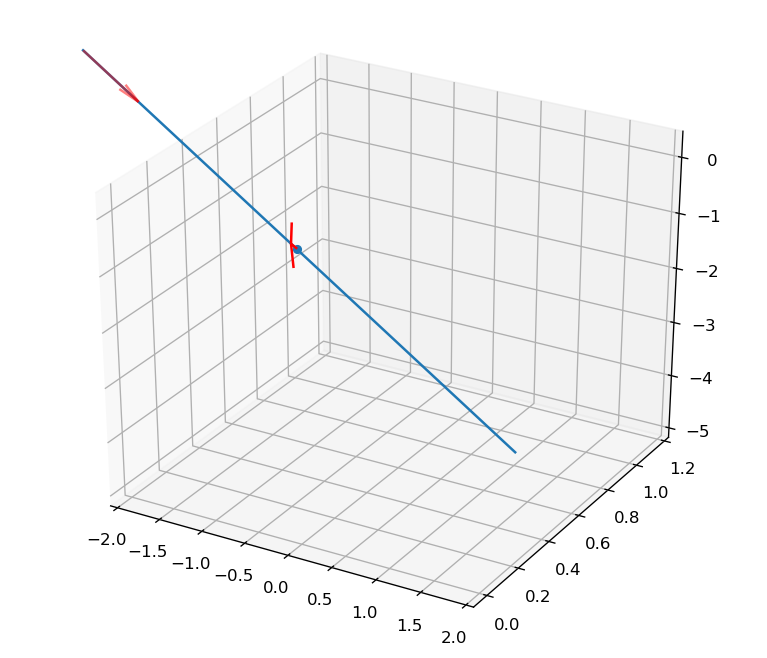

In [12]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111, projection='3d')

ax.plot(*np.concatenate(([entry_vecs[:,0]], [exit_vecs[:,0]]), axis=0).T)
ax.scatter(*c[0])
ax.quiver(*c[0], *(d[2][:,0]), color='red')
ax.quiver(*entry_vecs[:,0], *(d[1][:,0]), color='red', alpha=0.5)
ax.set(xlim=[-2,2])
plt.show()

In [13]:
assert np.dot(d[2][:,0],d[1][:,0]) < 1e-15

In [14]:
sensor_orientation = np.repeat(np.array([[0,0,1]]),N,axis=0).T

In [15]:
signal_test = signal(
    np.array([1]),
    np.array([1]),
    np.array([[0,0,1]]).T,
    np.array([[0,0,1]]).T,
    np.array([[0,0,1]]).T,
    mass=1
)

assert np.abs(G**2*np.pi/2 - signal_test[0]) < 1e-15

## Noise function definition

The $\sigma_{noise}$ from [this note](https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Analytic_SNR_for_a_single_sensor.pdf) is related to $\alpha$ from [Dan et. al.'s paper](https://arxiv.org/abs/1903.00492) in this way:

$$m_{sensor}^2\frac{\sigma_{noise}^2}{\Delta t} = \alpha$$

as such, we can try to recreate plots from Dan's papers without worrying about the noise bandwidth.

below in the code, I will use the noise parameter $\beta=\frac{\alpha}{m_{sensor}^2}$.

From the above linked note where I calculated the SNR expression, it can be seen that the SNR with template matching is simply $\sqrt{\frac{S}{\beta}}$.

In [16]:
def SNR(S, beta):
    '''SNR. based on https://github.com/windchimeproject/documentation_and_notes/blob/main/analysis_notes/Analytic_SNR_for_a_single_sensor.pdf'''
    return np.sqrt(S)/np.sqrt(beta)

def array_SNRs(sensor_pos, sensor_vectors, vel, entry_vecs, exit_vecs, beta, mass=mass_dm, return_individual_SNR=False, min_impact_parameter=min_impact_parameter, sensors_per_loop=100):
    '''Computes SNRs or S for entire array in a single function.
    If return_individual_SNR=True, instead of calculating the array SNR for each track,
    the Signal from each individual sensor is returned.
    This is much more memory inefficient as it returns a array with dimensions N_sensors x N_tracks,
    however it can allow one to run this function once and calculate the SNR for a variety of noise models.
    
    Parameters:
    sensor_pos: coordinates of sensors, 3xN array for N entries.
    sensor_vectors: sensor orientations. 3xN array; individual vectors assumed to be normalised.
    vel: array of velocity magnitudes.
    entry_vecs: vectors indicating the point at which tracks enter the analysis sphere,
                3xN array for N entries
    exit_vecs: vectors indicating the point at which tracks exit the analysis sphere,
               3xN array for N entries
    beta: noise amplitude parameter.
    mass: dark matter particle mass.
    return_individual_SNR: Boolean value indicating whether SNR for the array or S for each sensor should be returned.
    min_impact_parameter: Smallest allowable impact factor. Smaller impact factors are set to this value.
    sensors_per_loop: Number of sensors included in one vectorised operation.
                      The larger this value is, the more vectorised computation is.
                      The downside of simply setting this to the number of sensors is memory usage;
                      holding multiple arrays with ~10^9*10^3 entries becomes very unwieldy.
    
    '''
    N_sensors = sensor_pos.shape[1]
    N_vels = len(vel)
    if return_individual_SNR:
        S_outarr = np.zeros((N_sensors, N_vels))
        b_outarr = np.zeros((N_sensors, N_vels))+1e10
    else:
        S_outarr = np.zeros((N_vels))
        N_sq_outarr = np.zeros((N_vels))
        b_outarr = np.zeros((N_vels))+1e10
    loops = N_sensors//sensors_per_loop + bool(N_sensors%sensors_per_loop)
    for i in trange(loops):
        max_iter = min(sensors_per_loop, N_sensors-sensors_per_loop*i)
        sensor_pos_this_loop = np.repeat(sensor_pos[:,i*sensors_per_loop:i*sensors_per_loop+max_iter], N_vels, axis=1)
        sensor_vectors_this_loop = np.repeat(np.array([sensor_vectors[:,i]]), max_iter*N_vels, axis=0).T
        b_bases, v_bases, b_vecs = find_basis_vectors(sensor_pos_this_loop, np.tile(entry_vecs, max_iter), np.tile(exit_vecs, max_iter))
        b = np.linalg.norm(b_vecs,axis=0)
        S = signal(b, np.tile(vel, max_iter), sensor_vectors_this_loop, b_bases, v_bases, mass=mass, min_impact_parameter=min_impact_parameter)
        S = S.reshape(max_iter, -1)
        if return_individual_SNR:
            S_outarr[sensors_per_loop*i:i*sensors_per_loop+max_iter,:] = S
            b_outarr[sensors_per_loop*i:i*sensors_per_loop+max_iter,:] = b.reshape(max_iter, -1)
        else:
            S_outarr += np.sum(S, axis=0)
            N_sq_outarr += np.sum(S*beta, axis=0)
            b_outarr = np.minimum(b_outarr, np.min(b.reshape(max_iter, -1), axis=0))
    if return_individual_SNR:
        return S_outarr, b_outarr
    else:
        return S_outarr/np.sqrt(N_sq_outarr), b_outarr, N_sq_outarr

def array_SNRs_trackloop(sensor_pos, sensor_vectors, vel, entry_vecs, exit_vecs, beta, mass=mass_dm, return_individual_SNR=False, min_impact_parameter=min_impact_parameter):
    '''Computes SNRs or S for entire array in a single function.
    If return_individual_SNR=True, instead of calculating the array SNR for each track,
    the Signal from each individual sensor is returned.
    This is much more memory inefficient as it returns a array with dimensions N_sensors x N_tracks,
    however it can allow one to run this function once and calculate the SNR for a variety of noise models.
    
    Parameters:
    sensor_pos: coordinates of sensors, 3xN array for N entries.
    sensor_vectors: sensor orientations. 3xN array; individual vectors assumed to be normalised.
    vel: array of velocity magnitudes.
    entry_vecs: vectors indicating the point at which tracks enter the analysis sphere,
                3xN array for N entries
    exit_vecs: vectors indicating the point at which tracks exit the analysis sphere,
               3xN array for N entries
    beta: noise amplitude parameter.
    mass: dark matter particle mass.
    return_individual_SNR: Boolean value indicating whether SNR for the array or S for each sensor should be returned.
    min_impact_parameter: Smallest allowable impact factor. Smaller impact factors are set to this value.
    sensors_per_loop: Number of sensors included in one vectorised operation.
                      The larger this value is, the more vectorised computation is.
                      The downside of simply setting this to the number of sensors is memory usage;
                      holding multiple arrays with ~10^9*10^3 entries becomes very unwieldy.
    
    '''
    N_sensors = sensor_pos.shape[1]
    N_vels = len(vel)
    if return_individual_SNR:
        S_outarr = np.zeros((N_sensors, N_vels))
        b_outarr = np.zeros((N_sensors, N_vels))
    else:
        S_outarr = np.zeros((N_vels))
        N_sq_outarr = np.zeros((N_vels))
        b_outarr = np.zeros((N_vels))
    for i in trange(N_vels):
        b_bases, v_bases, b_vecs = find_basis_vectors(sensor_pos, np.repeat(entry_vecs[:,i:i+1], N_sensors, axis=1), np.repeat(exit_vecs[:,i:i+1], N_sensors, axis=1))
        b = np.linalg.norm(b_vecs,axis=0)
        S = signal(b, np.repeat(vel[i], N_sensors), sensor_vectors, b_bases, v_bases, mass=mass, min_impact_parameter=min_impact_parameter)
        if return_individual_SNR:
            S_outarr[:,i] = S
            b_outarr[:,i] = b
        else:
            S_outarr[i] = np.sum(S, axis=0)
            N_sq_outarr[i] = S_outarr[i]*beta
            b_outarr[i] = np.min(b)
    if return_individual_SNR:
        return S_outarr, b_outarr
    else:
        return S_outarr/np.sqrt(N_sq_outarr), b_outarr, N_sq_outarr

def array_SNRs_incorrect(sensor_pos, sensor_vectors, vel, entry_vecs, exit_vecs, beta, mass=mass_dm, return_individual_SNR=False, min_impact_parameter=min_impact_parameter):
    '''Computes SNRs for entire array in a single function.'''
    N_sensors = sensor_pos.shape[1]
    N_vels = len(vel)
    if return_individual_SNR:
        SNR_outarr = np.zeros((N_sensors, N_vels))
        b_outarr = np.zeros((N_sensors, N_vels))+1e10
    else:
        SNR_outarr = np.zeros((N_vels))
        b_outarr = np.zeros((N_vels))+1e10
    for i in trange(N_sensors):
        sensor_pos_this_loop = np.repeat(np.array([sensor_pos[:,i]]), N_vels, axis=0).T
        sensor_vectors_this_loop = np.repeat(np.array([sensor_vectors[:,i]]), N_vels, axis=0).T
        b_bases, v_bases, b_vecs = find_basis_vectors(sensor_pos_this_loop, entry_vecs, exit_vecs)
        b = np.linalg.norm(b_vecs,axis=0)
        S = signal(b, vel, sensor_vectors_this_loop, b_bases, v_bases, mass=mass, min_impact_parameter=min_impact_parameter)
        calculated_SNR = SNR(S, beta)
        if return_individual_SNR:
            SNR_outarr[i,:] = calculated_SNR
            b_outarr[i,:] = b
        else:
            SNR_outarr += calculated_SNR
            b_outarr = np.minimum(b_outarr, b)
    return SNR_outarr, b_outarr

In [17]:
np.repeat(entry_vecs[:,999:1000],1000,axis=1).shape

(3, 1000)

In [18]:
A_d = (sensor_mass/sensor_density)**(2/3) #sensor cross sectional area
beta = gas_pressure*A_d*np.sqrt(4*amu*k_B*4)/sensor_mass**2

In [19]:
SNR_1, b, N_sq_outarr_1 = array_SNRs(sensor_coords, sensor_vectors, vel, entry_vecs, exit_vecs, beta)

100%|██████████| 10304/10304 [05:20<00:00, 32.19it/s]   | 2/10304 [00:00<09:25, 18.22it/s]


In [20]:
SNR_1_trackloop,_,N_sq_1_trackloop = array_SNRs_trackloop(sensor_coords, sensor_vectors, vel, entry_vecs, exit_vecs, beta)

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]    | 1/1000 [00:00<05:56,  2.80it/s]


In [21]:
assert np.sum(np.abs((SNR_1_trackloop - SNR_1)/SNR_1_trackloop) < 1e-13)
assert np.sum(np.abs((N_sq_1_trackloop - N_sq_outarr_1)/N_sq_1_trackloop) < 1e-13)

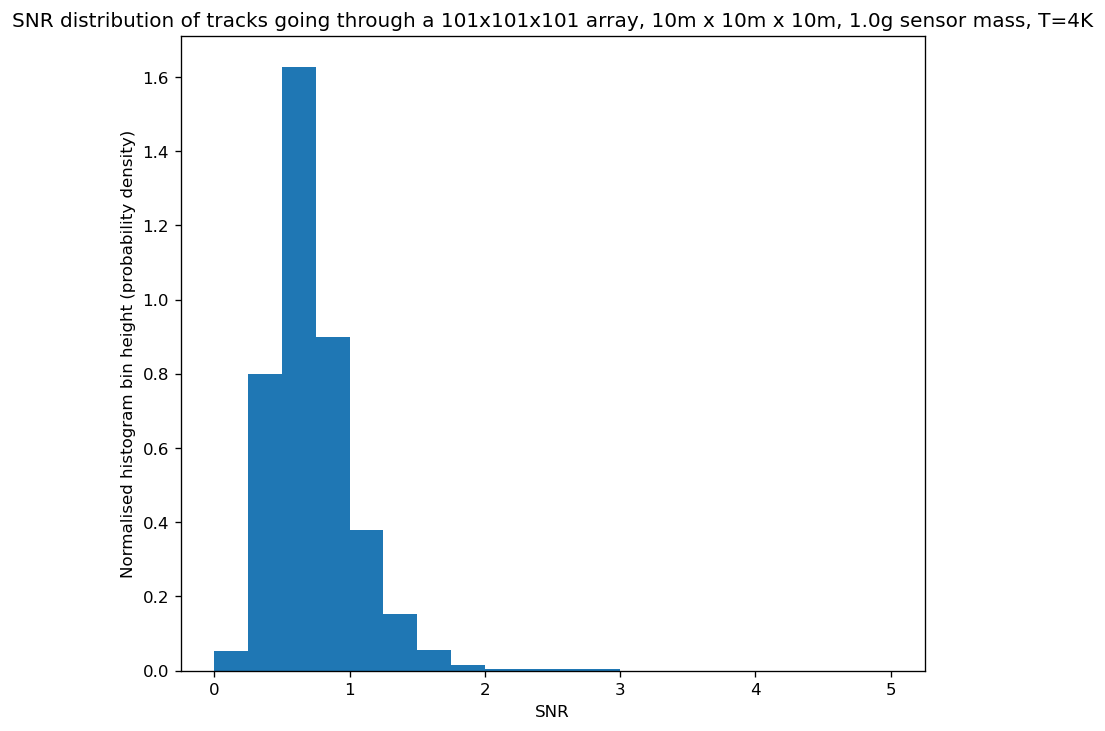

In [22]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(SNR_1_trackloop, density=True, bins=np.linspace(0,5,21))
ax.set(xlabel='SNR', ylabel='Normalised histogram bin height (probability density)', title=f'SNR distribution of tracks going through a {N_sensors_x}x{N_sensors_y}x{N_sensors_z} array, {length_x}m x {length_y}m x {length_z}m, {sensor_mass*1000}g sensor mass, T=4K')
plt.show()

In [23]:
SNR_1_higher_impact_factor, b_higher_impact_factor,_ = array_SNRs(sensor_coords, sensor_vectors, vel, entry_vecs, exit_vecs, beta, min_impact_parameter=0.02)

100%|██████████| 10304/10304 [05:08<00:00, 33.38it/s]   | 3/10304 [00:00<06:37, 25.90it/s]


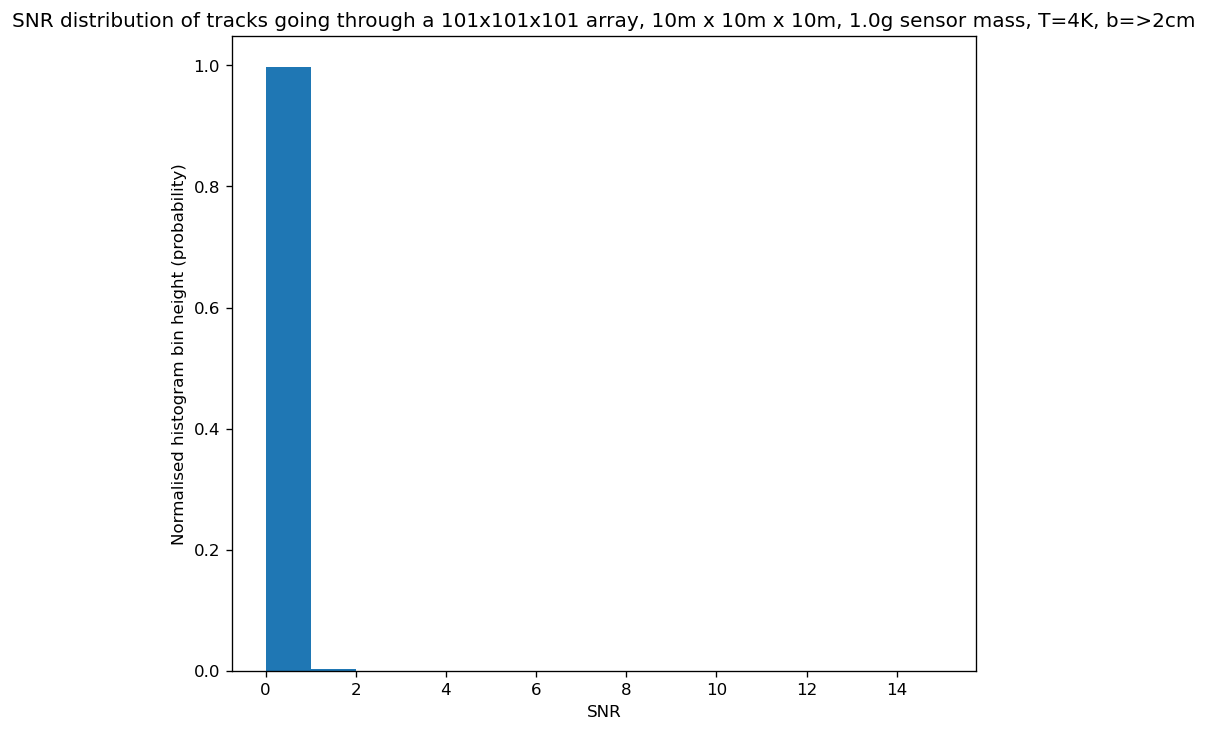

In [24]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(SNR_1_higher_impact_factor, density=True, bins=np.linspace(0,15,16))
ax.set(xlabel='SNR', ylabel='Normalised histogram bin height (probability)', title=f'SNR distribution of tracks going through a {N_sensors_x}x{N_sensors_y}x{N_sensors_z} array, {length_x}m x {length_y}m x {length_z}m, {sensor_mass*1000}g sensor mass, T=4K, b=>2cm')
plt.show()

In [25]:
S_2, b_2 = array_SNRs(sensor_coords, sensor_vectors, vel, entry_vecs, exit_vecs, beta, return_individual_SNR=True)

100%|██████████| 10304/10304 [05:05<00:00, 33.68it/s]   | 4/10304 [00:00<04:59, 34.34it/s]


In [28]:
S_2_trackloop, b_2_trackloop = array_SNRs_trackloop(sensor_coords, sensor_vectors, vel, entry_vecs, exit_vecs, beta, return_individual_SNR=True)

100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]    | 1/1000 [00:05<1:23:35,  5.02s/it]


In [29]:
assert np.sum(S_2_trackloop == S_2) == len(vel)*sensor_coords.shape[1]
assert np.sum(b_2_trackloop == b_2) == len(vel)*sensor_coords.shape[1]

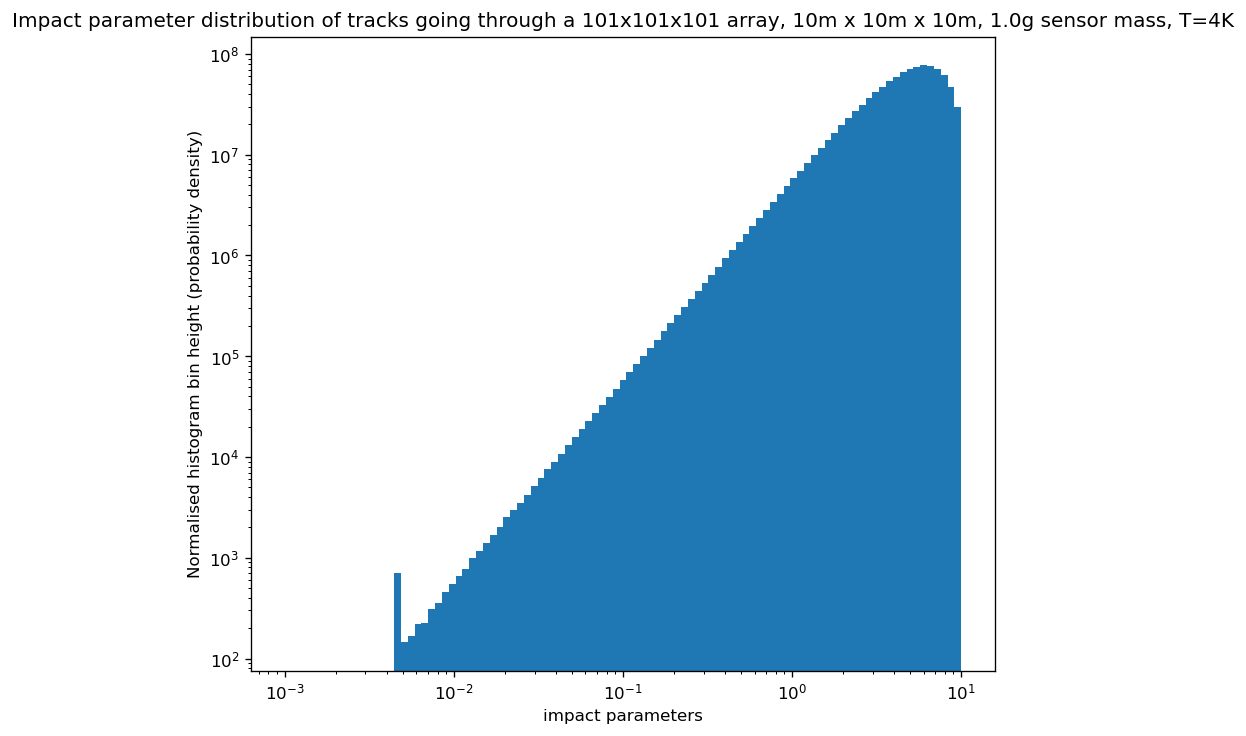

In [30]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(b_2_trackloop.reshape(-1,1), bins=np.logspace(-3,1,100))
ax.set(xlabel='impact parameters', ylabel='Normalised histogram bin height (probability density)', title=f'Impact parameter distribution of tracks going through a {N_sensors_x}x{N_sensors_y}x{N_sensors_z} array, {length_x}m x {length_y}m x {length_z}m, {sensor_mass*1000}g sensor mass, T=4K', xscale='log', yscale='log')
plt.show()

In [31]:
# np.savez_compressed(f'{N_sensors_x}_sensors_{length_x}_length_{N}_tracks', signal_strengths=S_2, impact_parameters=b_2)

In [32]:
best_3_contribution = []
best_N_contribution = []

for i in trange(N):
    sorted_indices = np.argsort(S_2_trackloop[:,i])
    best_3_contribution.append(np.sum(S_2_trackloop[:,i][sorted_indices[-3:]])/np.sum(S_2_trackloop[:,i]))
    best_N_contribution.append(np.sum(S_2_trackloop[:,i][sorted_indices[-N_sensors_x:]])/np.sum(S_2_trackloop[:,i]))

100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]    | 1/1000 [00:00<03:40,  4.54it/s]


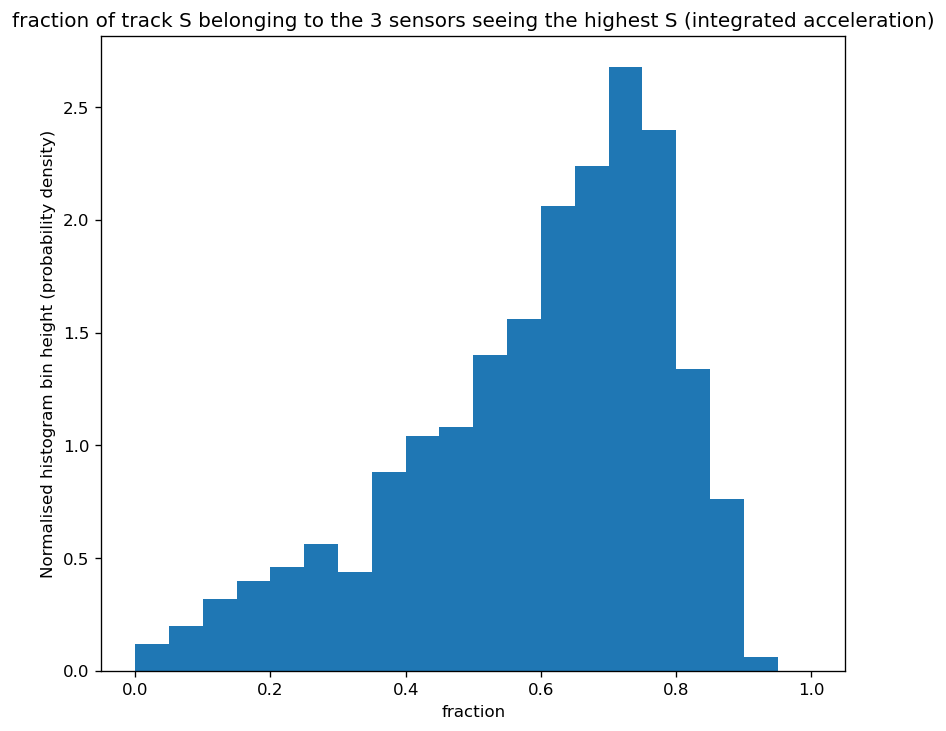

In [33]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(best_3_contribution, density=True, bins=np.linspace(0,1,21))
ax.set(xlabel='fraction', ylabel='Normalised histogram bin height (probability density)', title='fraction of track S belonging to the 3 sensors seeing the highest S (integrated acceleration)')
plt.show()

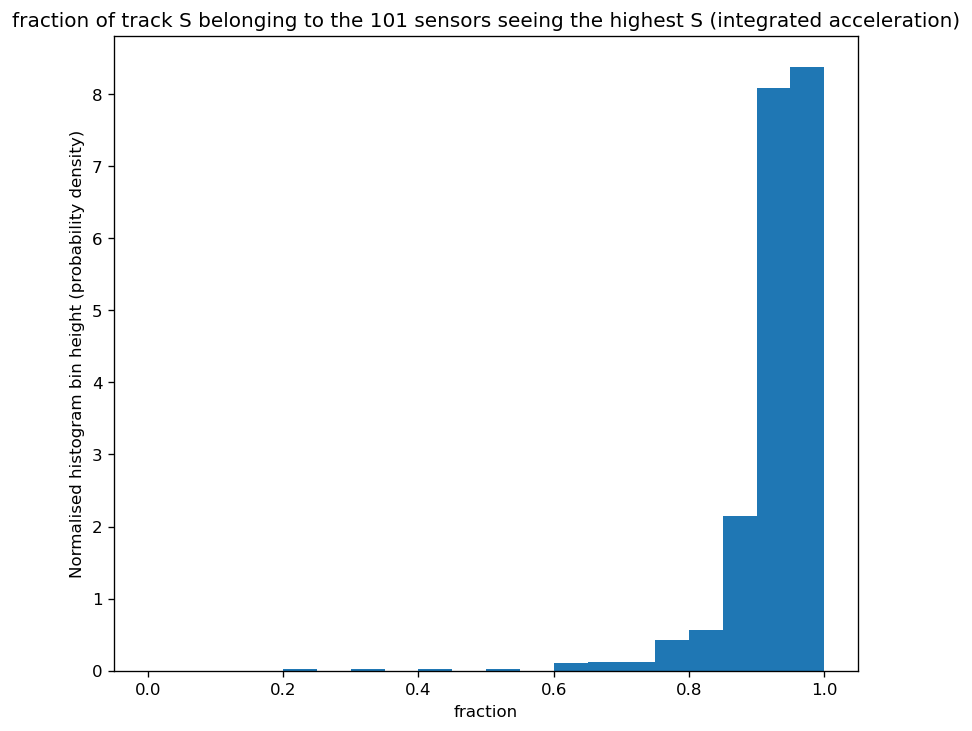

In [34]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.hist(best_N_contribution, density=True, bins=np.linspace(0,1,21))
ax.set(xlabel='fraction', ylabel='Normalised histogram bin height (probability density)', title=f'fraction of track S belonging to the {N_sensors_x} sensors seeing the highest S (integrated acceleration)')
plt.show()

In [35]:
v_dm = 220e3 #m/s
rho_dm = 0.3*GeV_per_c2*(100**3) #kg/m^3

In [36]:
@njit
def SNRs_from_S_and_beta(S, beta):
    '''Calculates the SNR from the output of array_SNRs, if return_individual_SNR=True.'''
    S_summed = np.sum(S, axis=0)
    return np.sqrt(S_summed/beta)

In [37]:
def beta_func(gas_pressure=gas_pressure, A_d=A_d, sensor_mass=sensor_mass, T=4):
    '''Noise model from https://arxiv.org/abs/1903.00492, for free-falling sensors.'''
    return gas_pressure*A_d*np.sqrt(4*amu*k_B*T)/sensor_mass**2

In [38]:
T_arr_edges = np.logspace(-3, 1, 51)
T_arr = T_arr_edges[:-1] + np.diff(T_arr_edges)/2
beta_arr = beta_func(T=T_arr)

In [39]:
expected_rate_through_radius = rho_dm*v_dm/mass_dm*3600*24*365*np.pi*radius**2 #events per year

In [40]:
SNR_threshold = 6
pdf_parameters = np.zeros((len(beta_arr), 2))
for i,b in enumerate(tqdm(beta_arr)):
    SNRs = SNRs_from_S_and_beta(S_2_trackloop, b)
    detected = np.sum(SNRs > SNR_threshold)
    pdf_parameters[i] = (detected+0.5, N+0.5-detected)

100%|██████████| 50/50 [00:51<00:00,  1.03s/it]      | 1/50 [00:02<01:48,  2.21s/it]


In [41]:
def toy_MC_poisson_detection(DM_rate, detection_probability_params, trials=100):
    '''Toy MC that returns the number of dark matter particles detected in 1 year of exposure.'''
    p_variable = stats.beta(*detection_probability_params)
    ps = p_variable.rvs(trials)
    DM_particles = stats.poisson(DM_rate).rvs(trials)
    detected_particles = stats.binom.rvs(DM_particles, ps)
    return detected_particles

In [42]:
multipliers_edges = np.linspace(0.5,5,151)
multipliers = np.linspace(0.5,5,151)

fraction_with_detections = np.zeros((len(beta_arr), len(multipliers)))
trials=10000

for i in trange(len(beta_arr)):
    for j,mult in enumerate(multipliers):
        detected_particles = toy_MC_poisson_detection(expected_rate_through_radius*mult, pdf_parameters[i], trials=trials)
        fraction_with_detections[i,j] = np.sum(detected_particles > 0)/trials

100%|██████████| 50/50 [01:02<00:00,  1.24s/it]      | 1/50 [00:01<01:09,  1.43s/it]


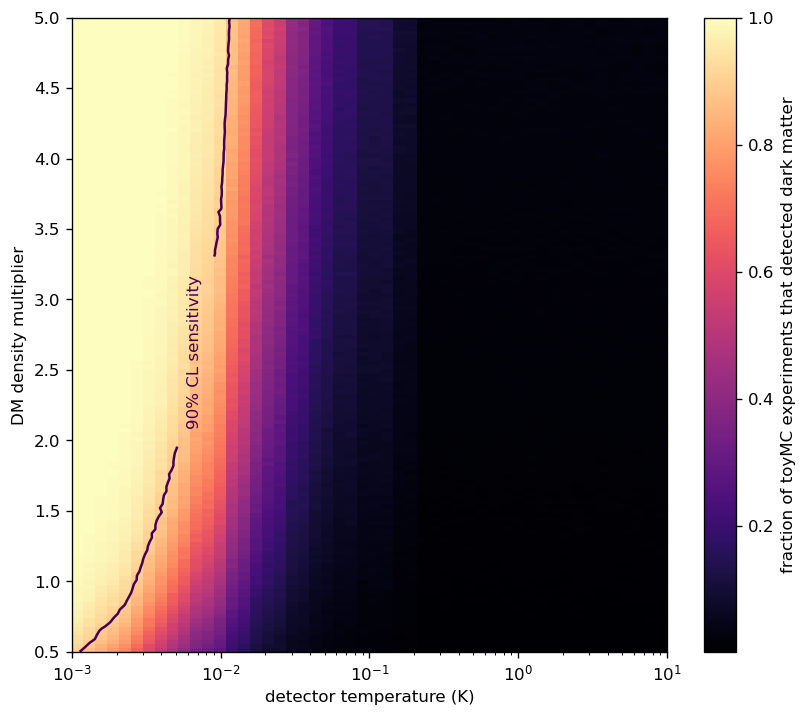

In [43]:
X,Y = np.meshgrid(T_arr_edges, multipliers_edges, indexing='ij')
X_points,Y_points = np.meshgrid(T_arr, multipliers, indexing='ij')
cmap = cm.get_cmap('magma')
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
s = ax.pcolormesh(X, Y, fraction_with_detections, cmap=cmap)
c = ax.contour(X_points, Y_points, fraction_with_detections, [0.9])
ax.clabel(c, c.levels, inline=True, fmt={c.levels[0]: '90% CL sensitivity'},)
cb = plt.colorbar(s)
cb.set_label('fraction of toyMC experiments that detected dark matter')
ax.set(xlabel='detector temperature (K)', ylabel='DM density multiplier', xscale='log')
plt.show()